In [79]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import numpy as np
import random

def fix_seed():
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)
    torch.cuda.manual_seed(42)

In [81]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,trained,logistic_regression,Transformer,,-1,-1,20,12,8,logistic_regression_standard
1,trained,lr_noise0.05,Transformer,train_noise_prob=0.05,-1,-1,20,12,8,lr_noise0.05
2,trained,lr_noise0.1,Transformer,train_noise_prob=0.1,-1,-1,20,12,8,lr_noise0.1
3,trained,lr_noise0.2,Transformer,train_noise_prob=0.2,-1,-1,20,12,8,noisy_logistic_regression_train0.2
14,trained,rbf_lr_noise0.2,Transformer,train_noise_prob=0.2,-1,-1,20,12,8,noisy_rbf_logistic_regression_train0.2
4,trained,rbf_logistic_regression,Transformer,,-1,-1,20,12,8,rbf_logistic_regression_standard
5,trained,rbf_lr_dim2,Transformer,,-1,-1,2,12,8,rbf_lr_dim2
6,trained,rbf_lr_dim2_noise0.1,Transformer,train_noise_prob=0.1,-1,-1,2,12,8,rbf_lr_dim2_noise0.1
7,trained,rbf_lr_noise0.05,Transformer,train_noise_prob=0.05,-1,-1,20,12,8,rbf_lr_noise0.05
13,trained,rbf_lr_noise0.1,Transformer,train_noise_prob=0.1,-1,-1,20,12,8,rbf_lr_noise0.1


In [82]:
def plot_metric(task, run_id, title=None, rbf_baselines_only=True, recompute_metrics=False):
    '''
        Plots the metric of given task and run_id.
        Set rbf_baselines_only to only show RBF baselines and the transformer.
    '''
    run_path = os.path.join(run_dir, task, run_id)
    if recompute_metrics:
        get_run_metrics(run_path)  # these are normally precomputed at the end of training

    def valid_row(r):
        return r.task == task and r.run_id == run_id

    metrics = collect_results(run_dir, df, valid_row=valid_row)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims

    models = metrics["standard"].keys()
    if rbf_baselines_only:
        models = [m for m in models if "Transformer" in m or "RBF" in m]
    basic_plot(metrics["standard"], y_axis_name="accuracy", models=models, trivial=0.5)
    plt.title(title if title else f"{task} {run_id}")
    plt.show()

100%|██████████| 1/1 [03:04<00:00, 184.85s/it]


rbf_logistic_regression_standard trained


100%|██████████| 1/1 [00:00<?, ?it/s]


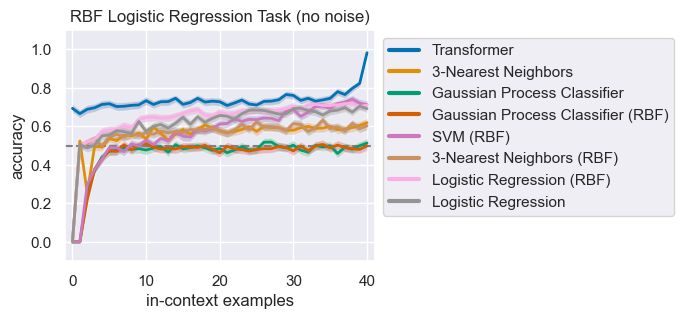

In [85]:
plot_metric("rbf_logistic_regression", "trained", "RBF Logistic Regression Task (no noise)", rbf_baselines_only=False)

Plotting training curves with respect to varying dimensions

rbf_lr_noise0.1_dim10 dim10


100%|██████████| 1/1 [00:00<?, ?it/s]


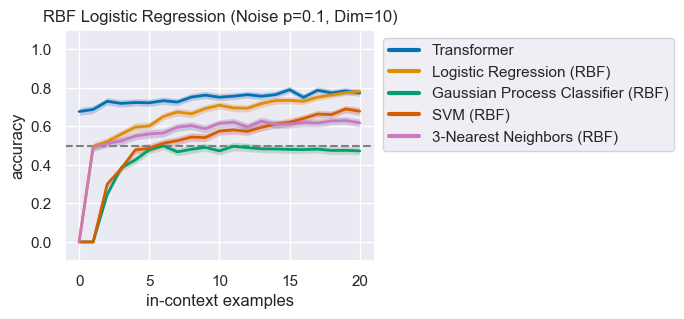

rbf_lr_noise0.1 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


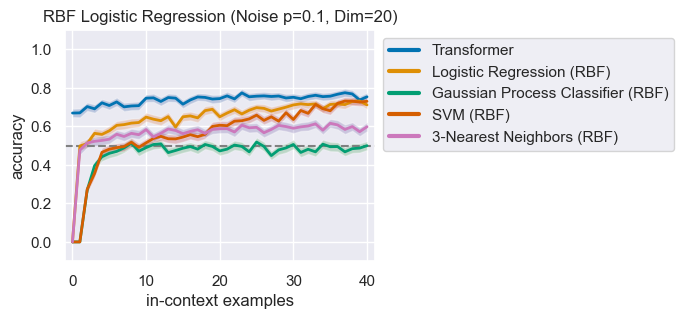

rbf_lr_noise0.1_dim30 dim30


100%|██████████| 1/1 [00:00<?, ?it/s]


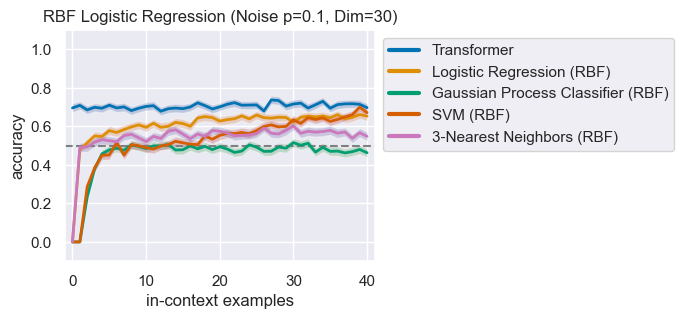

rbf_lr_noise0.1_dim40 dim40


100%|██████████| 1/1 [00:00<?, ?it/s]


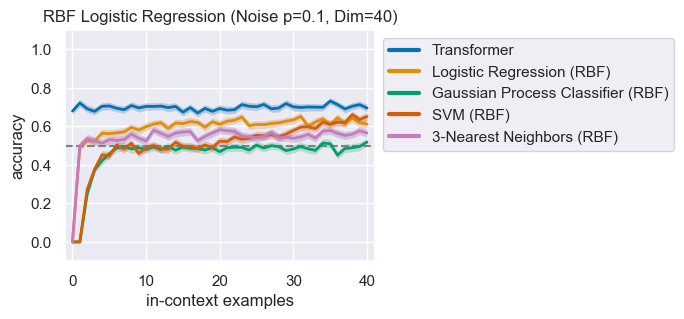

In [51]:
plot_metric("rbf_lr_noise0.1", "dim10", "RBF Logistic Regression (Noise p=0.1, Dim=10)")
plot_metric("rbf_lr_noise0.1", "trained", "RBF Logistic Regression (Noise p=0.1, Dim=20)")
plot_metric("rbf_lr_noise0.1", "dim30", "RBF Logistic Regression (Noise p=0.1, Dim=30)")
plot_metric("rbf_lr_noise0.1", "dim40", "RBF Logistic Regression (Noise p=0.1, Dim=40)")

Plotting training curves with respect to different model capacities

rbf_lr_noise0.1_small small


100%|██████████| 1/1 [00:00<?, ?it/s]


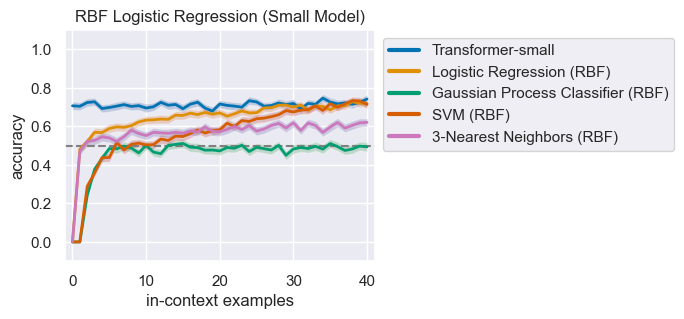

rbf_lr_noise0.1_tiny tiny


100%|██████████| 1/1 [00:00<?, ?it/s]


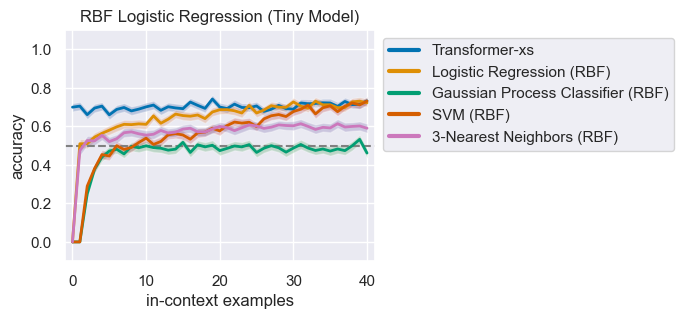

rbf_lr_noise0.1 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


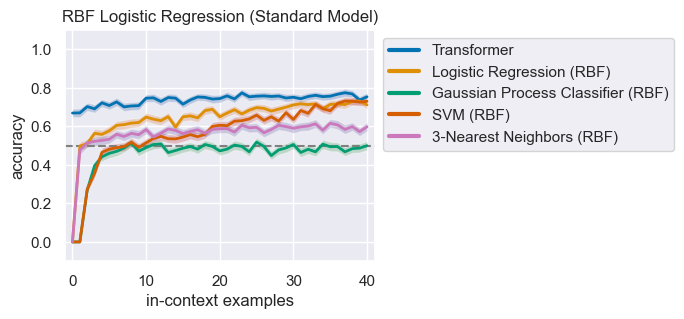

In [50]:
plot_metric("rbf_lr_noise0.1", "small", "RBF Logistic Regression (Small Model)")
plot_metric("rbf_lr_noise0.1", "tiny", "RBF Logistic Regression (Tiny Model)")
plot_metric("rbf_lr_noise0.1", "trained", "RBF Logistic Regression (Standard Model)")

Plotting training curves with respect to different noise probabilities

noisy_logistic_regression_train0.2 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


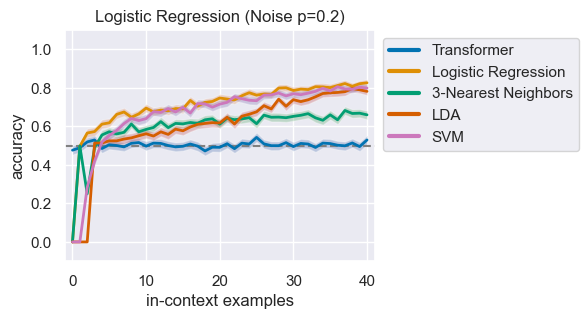

100%|██████████| 1/1 [03:37<00:00, 217.09s/it]


lr_noise0.1 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


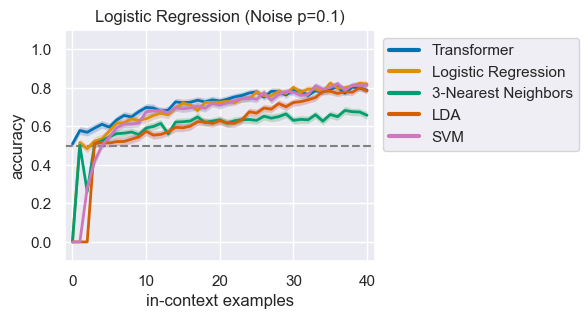

100%|██████████| 1/1 [03:13<00:00, 193.54s/it]


lr_noise0.05 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


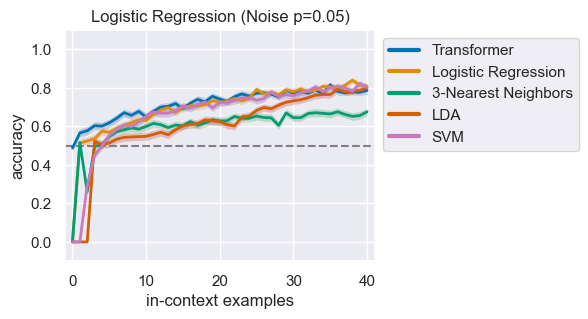

In [57]:
plot_metric("lr_noise0.2", "trained", "Logistic Regression (Noise p=0.2)", False, False)
plot_metric("lr_noise0.1", "trained", "Logistic Regression (Noise p=0.1)", False, True)
plot_metric("lr_noise0.05", "trained", "Logistic Regression (Noise p=0.05)", False, True)

Print result table

In [7]:
tasks = ["logistic_regression", "rbf_logistic_regression", "noisy_logistic_regression_train0.2", "noisy_rbf_logistic_regression_train0.2"]
run_id = "trained"

for t in tasks:
    print("task name:", t)

    def valid_row(r):
        return r.task == t and r.run_id == run_id

    metrics = collect_results(run_dir, df, valid_row=valid_row)['standard']
    for num_ex in [10, 20, 40]:
        print(num_ex)
        for k, v in metrics.items():
            print(k, round(v['mean'][num_ex], 4))

task name: logistic_regression
logistic_regression_standard trained


100%|██████████| 1/1 [00:00<?, ?it/s]


10
Transformer 0.6727
Logistic Regression 0.6477
3-Nearest Neighbors 0.6047
LDA 0.5602
SVM 0.6555
20
Transformer 0.7383
Logistic Regression 0.7484
3-Nearest Neighbors 0.6523
LDA 0.6273
SVM 0.7289
40
Transformer 0.8266
Logistic Regression 0.8109
3-Nearest Neighbors 0.643
LDA 0.8055
SVM 0.8047
task name: rbf_logistic_regression
rbf_logistic_regression_standard trained


100%|██████████| 1/1 [00:00<?, ?it/s]


10
Transformer 0.7336
3-Nearest Neighbors 0.5344
Gaussian Process Classifier 0.4773
Gaussian Process Classifier (RBF) 0.5109
SVM (RBF) 0.4898
3-Nearest Neighbors (RBF) 0.5672
20
Transformer 0.7281
3-Nearest Neighbors 0.5781
Gaussian Process Classifier 0.4852
Gaussian Process Classifier (RBF) 0.4625
SVM (RBF) 0.6086
3-Nearest Neighbors (RBF) 0.5758
40
Transformer 0.9828
3-Nearest Neighbors 0.6195
Gaussian Process Classifier 0.5141
Gaussian Process Classifier (RBF) 0.4992
SVM (RBF) 0.7195
3-Nearest Neighbors (RBF) 0.6031
task name: noisy_logistic_regression_train0.2
noisy_logistic_regression_train0.2 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


10
Transformer 0.4977
Logistic Regression 0.6953
3-Nearest Neighbors 0.5844
LDA 0.5617
SVM 0.6406
20
Transformer 0.4914
Logistic Regression 0.7477
3-Nearest Neighbors 0.6117
LDA 0.618
SVM 0.7156
40
Transformer 0.5297
Logistic Regression 0.8266
3-Nearest Neighbors 0.6602
LDA 0.782
SVM 0.7992
task name: noisy_rbf_logistic_regression_train0.2
noisy_rbf_logistic_regression_train0.2 trained


100%|██████████| 1/1 [00:00<?, ?it/s]

10
Transformer 0.6906
Logistic Regression (RBF) 0.6211
Logistic Regression 0.5992
3-Nearest Neighbors 0.5453
Gaussian Process Classifier 0.4883
Gaussian Process Classifier (RBF) 0.4789
SVM (RBF) 0.5188
3-Nearest Neighbors (RBF) 0.5555
20
Transformer 0.6977
Logistic Regression (RBF) 0.6953
Logistic Regression 0.6383
3-Nearest Neighbors 0.5789
Gaussian Process Classifier 0.475
Gaussian Process Classifier (RBF) 0.4898
SVM (RBF) 0.6008
3-Nearest Neighbors (RBF) 0.5945
40
Transformer 0.6773
Logistic Regression (RBF) 0.7242
Logistic Regression 0.7008
3-Nearest Neighbors 0.5789
Gaussian Process Classifier 0.5109
Gaussian Process Classifier (RBF) 0.4852
SVM (RBF) 0.6961
3-Nearest Neighbors (RBF) 0.6086


Plot pre-computed metrics

In [15]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

Experiment: Plot Transformer Model Performance wrt dimensions and model weights

In [64]:
def get_metric(task, run_id, recompute_metrics=False):
    '''
        Plots the metric of given task and run_id.
        Set rbf_baselines_only to only show RBF baselines and the transformer.
    '''
    run_path = os.path.join(run_dir, task, run_id)
    if recompute_metrics:
        get_run_metrics(run_path)  # these are normally precomputed at the end of training

    def valid_row(r):
        return r.task == task and r.run_id == run_id

    metrics = collect_results(run_dir, df, valid_row=valid_row)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims
    return metrics


rbf_lr_noise0.1 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


rbf_lr_noise0.1_small small


100%|██████████| 1/1 [00:00<?, ?it/s]


rbf_lr_noise0.1_tiny tiny


100%|██████████| 1/1 [00:00<?, ?it/s]


(0.6, 0.8)

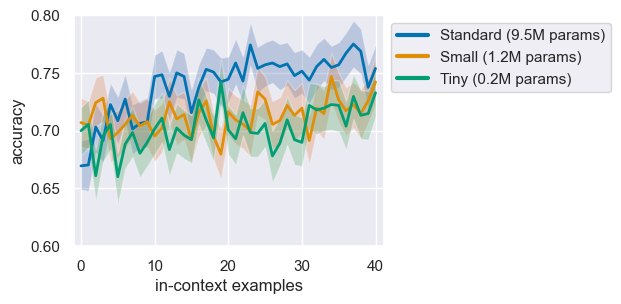

In [78]:
std_t = get_metric("rbf_lr_noise0.1", "trained")
small_t = get_metric("rbf_lr_noise0.1", "small")
tiny_t = get_metric("rbf_lr_noise0.1", "tiny")

gpt_metrics = {"Standard (9.5M params)" : std_t['standard']['Transformer'], "Small (1.2M params)" : small_t['standard']['Transformer-small'],\
    "Tiny (0.2M params)" : tiny_t['standard']['Transformer-xs']}
basic_plot(gpt_metrics, y_axis_name="accuracy", models=gpt_metrics.keys())
plt.ylim(0.6, 0.8)
# plt.figure()
# plt.xlabel("in-context examples")
# plt.ylabel("accuracy")
# plt.plot(std_t['standard']['Transformer']['mean'], label='Standard (9.5M params)')
# plt.plot(small_t['standard']['Transformer-small']['mean'], label='Small (1.2M params)')
# plt.plot(tiny_t['standard']['Transformer-xs']['mean'], label='Tiny (0.2M params)')
# plt.xlim(2, 42)
# plt.legend()

rbf_lr_noise0.1_dim10 dim10


100%|██████████| 1/1 [00:00<?, ?it/s]


rbf_lr_noise0.1 trained


100%|██████████| 1/1 [00:00<?, ?it/s]


rbf_lr_noise0.1_dim30 dim30


100%|██████████| 1/1 [00:00<?, ?it/s]


rbf_lr_noise0.1_dim40 dim40


100%|██████████| 1/1 [00:00<?, ?it/s]


(0.65, 0.85)

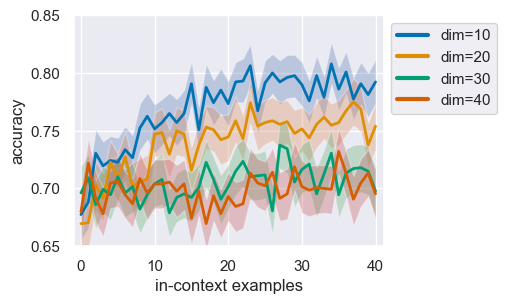

In [70]:
dim_metrics = {}
dim_metrics["dim=10"] = get_metric("rbf_lr_noise0.1", "dim10")['standard']['Transformer']
dim_metrics["dim=20"] = get_metric("rbf_lr_noise0.1", "trained")['standard']['Transformer']
dim_metrics["dim=30"] = get_metric("rbf_lr_noise0.1", "dim30")['standard']['Transformer']
dim_metrics["dim=40"] = get_metric("rbf_lr_noise0.1", "dim40")['standard']['Transformer']

basic_plot(dim_metrics, y_axis_name="accuracy", models=dim_metrics.keys())
plt.ylim(0.65, 0.85)

Experiment: Why does In-Context Learning with unkernelized LR not work with noise prob 0.2?

In [8]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [9]:
def get_task_and_data(task, run_id):
    run_path = os.path.join(run_dir, task, run_id)
    _, conf = get_model_from_run(run_path, only_conf=True)

    n_dims = conf.model.n_dims
    batch_size = conf.training.batch_size

    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )
    return task_sampler(), data_sampler

In [30]:
import seaborn as sns
def compute_and_plot(task, data_sampler):
    xs = data_sampler.sample_xs(b_size=1, n_points=300, seeds=[42])
    ys = task.evaluate(xs)
    xs_flat, ys_flat = xs[0], ys[0]
    xs_flat_ones = xs_flat[ys_flat == 1]
    xs_flat_zeros = xs_flat[ys_flat == -1]

    # fig, ax = plt.subplots()
    # ax.set_aspect(1)
    # ax.scatter(xs_flat_ones[:, 0], xs_flat_ones[:, 1])
    # ax.scatter(xs_flat_zeros[:, 0], xs_flat_zeros[:, 1])

    projected_x_ones = xs_flat_ones @ task.w_b[0]
    projected_x_zeros = xs_flat_zeros @ task.w_b[0]

    plt.figure()
    sns.kdeplot(projected_x_ones.flatten(), label='class 1', bw_method=0.2)
    sns.kdeplot(projected_x_zeros.flatten(), label='class 0', bw_method=0.2)
    plt.xlabel("Distance to decision boundary")
    plt.legend()
    plt.show()

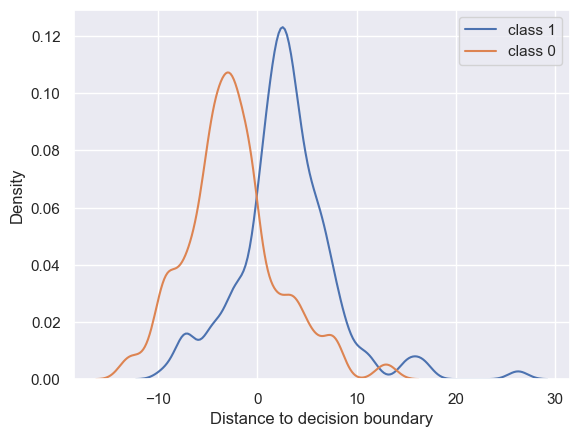

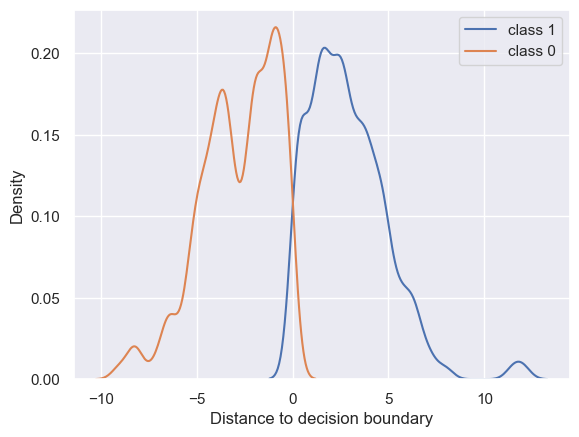

In [31]:
fix_seed()
task_1, data_sampler_1 = get_task_and_data("lr_noise0.2", "trained")
task_2, data_sampler_2 = get_task_and_data("logistic_regression", "trained")
compute_and_plot(task_1, data_sampler_1)
compute_and_plot(task_2, data_sampler_2)

For classification, the model is not robust when we scale all the inputs.

In [71]:
from analysis.query_scale import *
import numpy as np

In [72]:
def plot_scale_experiment(task, run_id):
    run_path = os.path.join(run_dir, task, run_id)
    mdl, conf = get_model_from_run(run_path)
    query_scale(mdl, conf, np.geomspace(0.1, 10, 50))

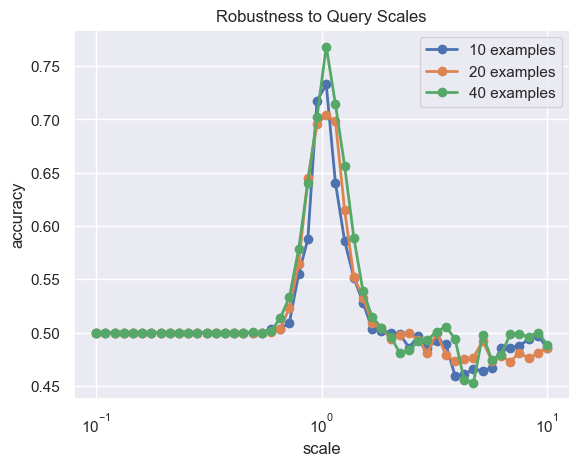

In [76]:
fix_seed()
plot_scale_experiment("rbf_logistic_regression", "trained")

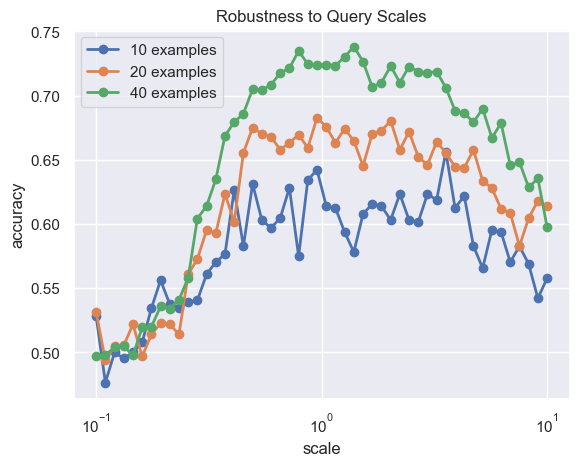

In [77]:
fix_seed()
plot_scale_experiment("logistic_regression", "trained")